In [1]:
import sys
import os
sys.path.insert(0,'../classes')
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import logging
import numpy as np

import coloredlogs

from arena import Arena
from coach import Coach
from beck.beck_game import BeckGame as Game
from beck.beck_nnet import NNetWrapper as nn
from beck.beck_players import HumanBeckPlayer
from mcts import MCTS
from utils import *
log = logging.getLogger(__name__)

from keras import backend as K

import tournament
participant_iters = tournament.participant_iters

participants_dir = '/scratch/zz737/fiar/tournaments/tournament_1/' # dir for trained networks
results_dir = '/scratch/zz737/fiar/tournaments/results/tournament_3/'
moves_dir = '/scratch/zz737/fiar/tournaments/tournament_3/moves/raw/'
splits_dir = '/scratch/zz737/fiar/tournaments/tournament_3/moves/splits/'
depth_dir = '/scratch/zz737/fiar/tournaments/tournament_3/depth_incomplete/'

{'mcts100_cpuct1': [1, 2, 3, 4, 6, 7, 9, 11, 12, 16, 18, 21, 25, 28, 29, 30, 37, 38, 39, 45, 47], 'mcts100_cpuct2': [1, 2, 3, 4, 6, 8, 12, 14, 15, 16, 21, 22, 24, 26, 27, 30, 32, 35, 39], 'mcts100_cpuct3': [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 16, 17, 18, 20, 21, 25, 26, 28, 32, 34, 35, 36], 'mcts25_cpuct1': [1, 2, 3, 4, 9, 11, 13, 14, 16, 19, 22, 25, 28, 29, 31, 37, 39, 45, 59, 61], 'mcts50_cpuct1': [1, 2, 3, 4, 5, 6, 7, 9, 10, 13, 17, 18, 20, 21, 23, 25, 28, 29, 31, 37, 39, 41, 44, 45, 47, 48, 53], 'mcts80_cpuct1': [1, 2, 3, 4, 5, 7, 8, 9, 10, 13, 16, 19, 20, 21, 23, 24, 28, 34, 35, 36, 40], 'mcts80_cpuct2': [1, 2, 5, 6, 8, 10, 12, 13, 15, 17, 18, 19, 22, 25, 28, 30, 31, 34, 37, 38, 39, 40, 43, 45, 46, 51], 'mcts80_cpuct3': [1, 2, 5, 6, 7, 9, 12, 13, 14, 19, 21, 22, 23, 24, 26, 27, 28, 35, 36, 42, 43, 47, 49, 50, 51, 53, 54, 55, 56, 57]}
189 participant iterations!


In [2]:
# pruning threshold, stopping probability, feature drop rate, lapse rate, active-passive scaling constant, center feature, and the 4 positional features (connected 2 in a row, unconnected 2 in a row, 3 in a row, 4 in a row)

params_names = ['pruning_thresh','stop_p','feat_drop','lapse','active_passive','center','2_con','2_uncon','3','4']

In [6]:
sub_dir = '/scratch/zz737/fiar/tournaments/tournament_3/moves/splits_incomplete/1/'


2.6899428571428574

In [5]:
def read_one_subject(sub_dir,params_names=None,name='_'):
    if params_names is None:
        params_names = ['pruning_thresh','stop_p','feat_drop','lapse','active_passive','center','two_con','two_uncon','three','four','lltest']
    params_l = []
    for i in range(1,6):
        fn = sub_dir+'params'+str(i)+'.csv'
        try:
            params = np.loadtxt(fn,delimiter=',')
            ll_fn = sub_dir+f'lltest{i}.csv'
            ll = np.mean(np.loadtxt(ll_fn))
            params=np.append(params,ll)

            params_l.append(params)
        except:
            pass
        
    params_l = np.vstack(params_l)
    params_df = pd.DataFrame(params_l,columns=params_names)
    
    if 'mcts' in name:
        subname, iter = name.split(';')
        iter = int(iter)        
        mcts = int(subname.split('_')[0][4:])
        cpuct = int(subname.split('_')[1][5:])

    
        
        params_df['mcts'] = mcts
        params_df['cpuct'] = cpuct
        params_df['iter'] = iter
    
    params_names.extend(['mcts','cpuct','iter'])
    params_df = params_df.reindex(params_names,axis=1)
    
#     if isdepth:
#         subj_index = int(sub_dir.split('/')[-1])
    
#     params_df.loc[:,'mcts':'iter'] = params_df.loc[:,'mcts':'iter'].astype('int16')
    
    return params_df

def get_subject_name(sub_dir):
    fn = sub_dir+'1.csv'
    moves = np.loadtxt(fn,delimiter=',', dtype='str')
    name = moves[0].split('\t')[-2]
    return name

def read_all_subjects(splits_dir,params_names=None):
    params_all_subj_dict = {}
    for sub_dir in os.listdir(splits_dir):
        sub_dir = splits_dir + sub_dir + '/'
        name = get_subject_name(sub_dir)
        
        params_all_subj_dict[name] = read_one_subject(sub_dir,params_names=params_names,name=name)
    params_all_subj_dict = pd.concat(params_all_subj_dict,keys=params_all_subj_dict.keys())
    
    return params_all_subj_dict
    


In [6]:
params_all_subj_dict = read_all_subjects(splits_dir,None)
params_all_nn = params_all_subj_dict.dropna()

In [8]:
params_all_subj_dict.loc['greedy']

,pruning_thresh,stop_p,feat_drop,lapse,active_passive,center,two_con,two_uncon,three,four,lltest,mcts,cpuct,iter
0,9.29530,0.977490,0.006592,0.050000,0.27588,9.4373,0.568850,7.7478,1.7346,-5.87770,2.709271,NaN,NaN,NaN
1,0.15714,0.574490,0.399300,0.055596,0.89632,7.7544,-4.285000,1.1368,1.5231,2.79440,2.734543,NaN,NaN,NaN
2,0.30626,0.005103,0.501270,0.107650,1.53090,4.6844,-0.015259,-5.5521,-3.1699,2.49110,2.683657,NaN,NaN,NaN
3,0.45319,0.098451,0.212800,0.059565,0.88450,3.5724,0.503180,2.0597,2.5894,-0.36749,2.640271,NaN,NaN,NaN
4,0.72092,0.275860,0.066419,0.057027,1.10860,9.9629,-1.468500,-8.4579,2.1547,-2.72430,2.692086,NaN,NaN,NaN


In [9]:
params_all_nn

pruning_thresh    stop_p  feat_drop     lapse  \
mcts25_cpuct1;16 0         1.59730  0.047538    0.24629  0.050561   
                 1         2.10230  0.024093    0.35408  0.050000   
                 2         1.30550  0.050404    0.28311  0.162420   
                 3         2.05000  0.020171    0.21603  0.109950   
                 4         1.71160  0.030968    0.23731  0.050006   
...                            ...       ...        ...       ...   
mcts100_cpuct3;5 0         0.14788  0.970100    0.20630  0.050000   
                 1         1.38240  0.016446    0.12582  0.056637   
                 2         9.96270  0.013051    0.44899  0.050279   
                 3         3.51900  0.015080    0.25295  0.097494   
                 4         3.47550  0.054019    0.15924  0.060175   

                    active_passive     center  two_con  two_uncon   three  \
mcts25_cpuct1;16 0         1.17260   0.577050  0.57071    0.44604  4.4227   
                 1         1.70680   0.446470  0.85266    0.43518  3.7424   
                 2         1.60560   0.007722  0.71803    0.74626  4.1525   
                 3         1.26600   0.145770  1.00140   -0.42575  5.0709   
                 4         1.21900   0.807670  0.75139    0.63731  5.2491   
...                            ...        ...      ...        ...     ...   
mcts100_cpuct3;5 0         0.35645  10.000000 -2.17770    0.56641  5.5713   
                 1         0.25019   0.362240 -0.47088    1.05440  4.1664   
                 2         0.27055   1.312000  1.40840    2.72530  5.2490   
                 3         1.11080   0.932960  0.81628    1.06040  3.5498   
                 4         0.93524   0.968020  1.16210    1.49050  4.0759   

                       four    lltest   mcts  cpuct  iter  
mcts25_cpuct1;16 0   9.9147  2.829686   25.0    1.0  16.0  
                 1   9.8190  1.827357   25.0    1.0  16.0  
                 2   7.8519  2.636514   25.0    1.0  16.0  
                 3   9.9609  2.932029   25.0    1.0  16.0  
                 4   9.8488  2.945100   25.0    1.0  16.0  
...                     ...       ...    ...    ...   ...  
mcts100_cpuct3;5 0   1.0254  2.618500  100.0    3.0   5.0  
                 1   9.8295  2.907529  100.0    3.0   5.0  
                 2   3.3824  3.105771  100.0    3.0   5.0  
                 3   9.8645  1.773300  100.0    3.0   5.0  
                 4  10.0000  3.013657  100.0    3.0   5.0  

[934 rows x 14 columns]

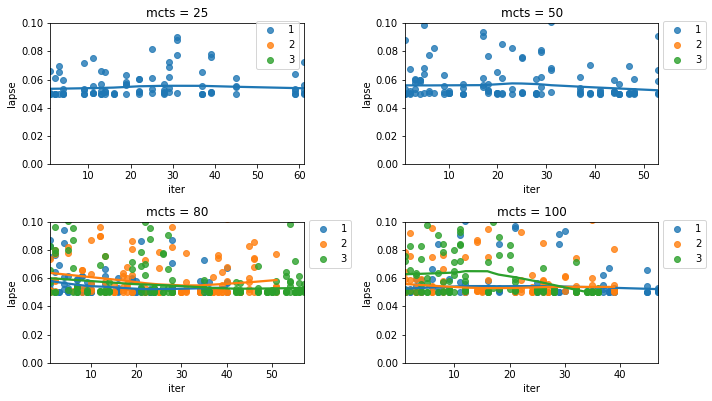

In [10]:
fig = plt.figure(figsize=(5*2,4*2))
axs=[]
for ii,mcts in enumerate([25,50,80,100]):
    axs.append(fig.add_subplot(3,2,ii+1))
    axs[ii].set_title(f'mcts = {mcts}')
    for cpuct in [1,2,3]:
        mask = (params_all_nn['mcts']==mcts)&(params_all_nn['cpuct']==cpuct)&(params_all_nn['iter']>=0)
        axs[ii]=sns.regplot(x='iter',y='lapse',data=params_all_nn.loc[mask],ax=axs[ii],label=str(cpuct),lowess=True)
    axs[ii].legend(bbox_to_anchor=[1,1.05])
    axs[ii].set_ylim([0,0.1])
plt.tight_layout()

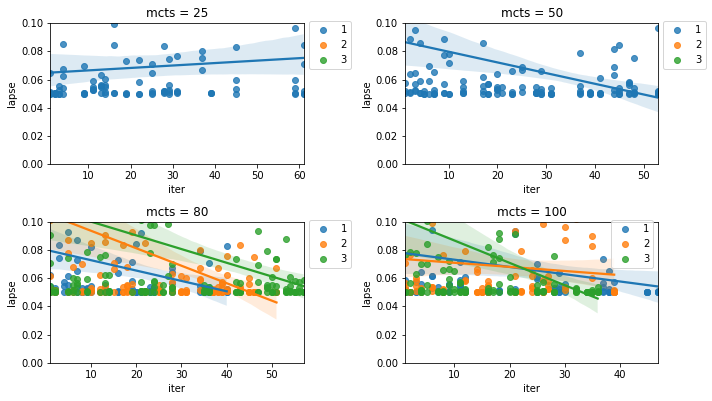

In [27]:
fig = plt.figure(figsize=(5*2,4*2))
axs=[]
for ii,mcts in enumerate([25,50,80,100]):
    axs.append(fig.add_subplot(3,2,ii+1))
    axs[ii].set_title(f'mcts = {mcts}')
    for cpuct in [1,2,3]:
        mask = (params_all_nn['mcts']==mcts)&(params_all_nn['cpuct']==cpuct)&(params_all_nn['iter']>=0)
        axs[ii]=sns.regplot(x='iter',y='lapse',data=params_all_nn.loc[mask],ax=axs[ii],label=str(cpuct),lowess=False)
    axs[ii].legend(bbox_to_anchor=[1,1.05])
    axs[ii].set_ylim([0,0.1])
plt.tight_layout()

In [5]:
import statsmodels.formula.api as smf
res = smf.ols(formula='pruning_thresh~C(mcts)+C(cpuct)+iter',data=params_all_nn).fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:         pruning_thresh   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     40.89
Date:                Thu, 21 Jan 2021   Prob (F-statistic):           2.56e-44
Time:                        11:30:45   Log-Likelihood:                -2397.8
No. Observations:                 935   AIC:                             4810.
Df Residuals:                     928   BIC:                             4844.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3311      0.353  

In [19]:
import scipy
params_all_nn_stdz = params_all_nn.apply(scipy.stats.zscore)

In [28]:
from patsy import dmatrix
dmatrix('C(mcts)+C(cpuct)+iter',data=params_all_nn)

DesignMatrix with shape (935, 7)
  Columns:
    ['Intercept',
     'C(mcts)[T.50.0]',
     'C(mcts)[T.80.0]',
     'C(mcts)[T.100.0]',
     'C(cpuct)[T.2.0]',
     'C(cpuct)[T.3.0]',
     'iter']
  Terms:
    'Intercept' (column 0)
    'C(mcts)' (columns 1:4)
    'C(cpuct)' (columns 4:6)
    'iter' (column 6)
  (to view full data, use np.asarray(this_obj))

In [23]:
import statsmodels.formula.api as smf
res = smf.ols(formula='three~(mcts)+(cpuct)+iter',data=params_all_nn_stdz).fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                  three   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     64.25
Date:                Thu, 21 Jan 2021   Prob (F-statistic):           9.20e-38
Time:                        11:45:38   Log-Likelihood:                -1238.7
No. Observations:                 935   AIC:                             2485.
Df Residuals:                     931   BIC:                             2505.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    3.73e-17      0.030   1.25e-15      1.0

In [25]:
import statsmodels.formula.api as smf
res = smf.ols(formula='two_uncon~C(mcts)+C(cpuct)+iter',data=params_all_nn).fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:              two_uncon   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6208
Date:                Wed, 20 Jan 2021   Prob (F-statistic):              0.714
Time:                        17:23:26   Log-Likelihood:                -2016.9
No. Observations:                 935   AIC:                             4048.
Df Residuals:                     928   BIC:                             4082.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2948      0.235  

In [69]:
params_all_subj_dict.corr()

,pruning_thresh,stop_p,feat_drop,lapse,active_passive,center,2_con,2_uncon,3,4,mcts,cpuct,iter
pruning_thresh,1.000000,-0.155869,-0.030039,-0.032141,-0.241472,-0.174622,0.096074,-0.028627,0.341740,0.251447,0.156002,0.011960,0.355683
stop_p,-0.155869,1.000000,0.057939,0.094949,0.065054,0.178860,-0.134864,0.100604,-0.092573,-0.182805,-0.069188,0.012283,-0.152383
feat_drop,-0.030039,0.057939,1.000000,0.206829,-0.102006,-0.104038,-0.014457,-0.033342,0.201787,0.158502,0.021489,0.049537,-0.169095
lapse,-0.032141,0.094949,0.206829,1.000000,0.093530,-0.066577,-0.049162,-0.090004,-0.006682,-0.148018,0.020894,0.086500,-0.191303
active_passive,-0.241472,0.065054,-0.102006,0.093530,1.000000,0.177648,0.137931,-0.040748,-0.363551,-0.480813,-0.085785,-0.046740,-0.177818
center,-0.174622,0.178860,-0.104038,-0.066577,0.177648,1.000000,0.097711,-0.221422,-0.162871,-0.416544,-0.125341,-0.063672,-0.181782
2_con,0.096074,-0.134864,-0.014457,-0.049162,0.137931,0.097711,1.000000,-0.257722,0.045699,-0.014231,-0.022646,-0.114819,0.066125
2_uncon,-0.028627,0.100604,-0.033342,-0.090004,-0.040748,-0.221422,-0.257722,1.000000,-0.119221,0.046718,0.018919,0.024465,0.022922
3,0.341740,-0.092573,0.201787,-0.006682,-0.363551,-0.162871,0.045699,-0.119221,1.000000,0.566678,0.163595,0.073783,0.356781
4,0.251447,-0.182805,0.158502,-0.148018,-0.480813,-0.416544,-0.014231,0.046718,0.566678,1.000000,0.165836,0.091774,0.377844


In [78]:
sorted(['a;1','a;13','a;2'],key=lambda x:int(x.split(';')[1]))

['a;1', 'a;2', 'a;13']

In [11]:
sort_key = lambda x:[int(xx.split(';')[1]) for xx in x]
def sort_key(index):
    index_mod = []
    for xx in index:
        xx_sp = xx.split(';')
        if len(xx_sp)>=2:
            toappend = int(xx_sp[1]) # the ones containing iteration numbers
        else:
            toappend = 0 # like greedy, without numerical index
        index_mod.append(toappend)
    return pd.Index(index_mod)
                           
        
    
params_all_subj_dict.groupby(level=0).mean().sort_index(level=0,key=sort_key)

,pruning_thresh,stop_p,feat_drop,lapse,active_passive,center,2_con,2_uncon,3,4
greedy,0.315132,0.436495,0.338308,0.065162,0.969904,5.530640,-0.479694,0.227546,2.150562,-0.689336
random,2.715550,0.012513,0.002495,0.050580,2.670490,7.326600,0.354340,0.487720,4.502760,-4.901380
mcts80_cpuct3;1,0.244908,0.070907,0.034132,0.063431,1.531512,-6.389380,-2.896157,4.399710,-6.503760,-4.106620
mcts100_cpuct3;1,0.377106,0.006432,0.139763,0.055301,1.805060,-2.285040,4.788382,1.311656,-3.466168,-2.250860
mcts80_cpuct1;1,0.905004,0.383107,0.097423,0.063921,2.030420,-0.940736,-1.810920,3.166332,2.535320,0.695242
...,...,...,...,...,...,...,...,...,...,...
mcts80_cpuct3;55,6.062946,0.007026,0.089985,0.051638,0.697656,0.262664,1.137856,-0.219394,4.690480,9.884720
mcts80_cpuct3;56,2.262604,0.257820,0.056370,0.063816,1.111748,-0.410176,1.130678,0.831810,5.305620,9.967220
mcts80_cpuct3;57,0.169346,0.516907,0.173014,0.051897,1.241560,-0.549018,1.075416,0.395041,4.106400,9.810760
mcts25_cpuct1;59,8.235800,0.001230,0.052964,0.061956,0.716562,1.156822,1.297810,0.719008,5.838180,9.802840


In [42]:
params_all_subj_dict.dropna()['2_con']

mcts25_cpuct1;16  0    1.35820
                  1    0.89571
                  2    1.06810
                  3    1.17640
                  4    1.26810
                        ...   
mcts100_cpuct3;5  0    1.57450
                  1    0.99477
                  2    0.36984
                  3    0.86731
                  4   -8.56400
Name: 2_con, Length: 935, dtype: float64

In [31]:
sub_dir = splits_dir+'1/'

In [32]:
read_one_subject(sub_dir)

,pruning_thresh,stop_p,feat_drop,lapse,active_passive,center,con_2,uncon_2,3,4
0,0.44496,0.041826,0.84617,0.070242,0.82501,5.1331,-0.48239,0.10017,-0.41439,-8.978200
1,0.52776,0.229450,0.15647,0.068198,1.08350,4.4865,2.16350,-0.21472,1.06960,0.097971
2,0.14683,0.540990,0.22521,0.071314,0.92105,6.1696,-0.95098,-1.20880,4.53700,0.413270
3,0.32947,0.370340,0.24512,0.054185,0.97406,7.6904,-2.06790,-0.90942,3.02250,-0.413820
4,0.12664,0.999870,0.21857,0.061870,1.04590,4.1736,-1.06070,3.37050,2.53810,5.434100


In [5]:
x = os.listdir(splits_dir)[0]

In [14]:
os.listdir(splits_dir+x)
np.loadtxt(splits_dir+x+'/params1.csv',delimiter=',')

array([ 0.93409 ,  0.039235,  0.22208 ,  0.05018 ,  0.39444 ,  9.9967  ,
        1.3582  , -1.0697  ,  5.6738  ,  7.0965  ])

In [20]:
np.loadtxt(splits_dir+x+'/lltrain3.csv',delimiter=',')

array([59.073, 53.199, 59.155, 62.256, 61.909, 61.973, 64.295, 66.699,
       65.085, 59.572])